# Variational Autoencoder (VAE) Training for BP Prediction

This notebook implements and trains a Variational Autoencoder for encoding PVI images into a latent space. The trained VAE encoder will later be used as the embedding component for the LSTM-based BP prediction model.

## Setup and Imports

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import sys

# Add parent directory to path for importing custom modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))  # Adjust as needed
from utils.data_utils import DataPathManager, PviDataset, PviBatchServer

# Create output directory
output_dir = "vae_output"
os.makedirs(output_dir, exist_ok=True)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. VAE Model Definition

Define the Variational Autoencoder architecture with convolutional layers

In [11]:
class VAE(nn.Module):
    """
    Variational Autoencoder for encoding PVI images into a latent space
    """
    def __init__(self, image_size=32, image_channels=1, latent_dim=64):
        super(VAE, self).__init__()
        
        # Encoder network
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Flatten()
        )
        
        # Calculate flattened size after convolutions
        conv_output_size = 256 * (image_size // 16) * (image_size // 16)
        
        # Mean and log variance projections for latent space
        self.fc_mu = nn.Linear(conv_output_size, latent_dim)
        self.fc_logvar = nn.Linear(conv_output_size, latent_dim)
        
        # Decoder network
        self.decoder_input = nn.Linear(latent_dim, conv_output_size)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, image_size // 16, image_size // 16)),
            
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(32, image_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.decoder_input(z)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

## 2. Image Dataset Creation

Define the custom dataset class for extracting individual images from the dataloader for VAE training

In [12]:
class ImageDataset(Dataset):
    """
    Dataset for training the VAE on individual images from the sequence
    """
    def __init__(self, dataloader):
        self.images = []
        
        for batch in tqdm(dataloader, desc="Building image dataset"):
            # Extract images
            img_batch = batch['pviHP']  # [batch_size, 1, 32, 32, 500]
            
            # Process each sample
            for i in range(img_batch.size(0)):
                # Get all 500 images for this sample
                sample_images = img_batch[i]  # [1, 32, 32, 500]
                
                # Transpose to get [500, 1, 32, 32]
                sample_images = sample_images.permute(3, 0, 1, 2)
                
                # Add to our dataset
                self.images.append(sample_images)
        
        # Concatenate all images
        self.images = torch.cat(self.images, dim=0)
        
        # Normalize images to [0, 1] range if not already normalized
        if self.images.max() > 1.0:
            print("Normalizing images to [0, 1] range...")
            self.images = self.images / self.images.max()
        
        # Check for NaN or infinite values
        if torch.isnan(self.images).any() or torch.isinf(self.images).any():
            print("WARNING: Dataset contains NaN or infinite values. Replacing with zeros...")
            self.images = torch.nan_to_num(self.images, nan=0.0, posinf=1.0, neginf=0.0)
        
        # Print dataset statistics
        print(f"Created dataset with {len(self.images)} images")
        print(f"Image tensor shape: {self.images.shape}")
        print(f"Image value range: [{self.images.min().item():.6f}, {self.images.max().item():.6f}]")
        print(f"Image mean: {self.images.mean().item():.6f}, std: {self.images.std().item():.6f}")
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx]

## 3. VAE Training Function

Define the function for training the VAE on image data

In [13]:
def check_model_init(model):
    """Verify model weights are properly initialized"""
    has_nan = False
    for name, param in model.named_parameters():
        if torch.isnan(param).any():
            print(f"WARNING: NaN values found in {name}")
            has_nan = True
    return not has_nan

def train_vae(vae, dataloader, num_epochs=30, learning_rate=5e-5, device='cuda', checkpoint_dir='checkpoints'):
    """Train the VAE model on image data"""
    print("Preparing VAE training data...")
    optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)
    vae.to(device)
    
    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Create a dataset of individual images
    image_dataset = ImageDataset(dataloader)
    image_loader = DataLoader(image_dataset, batch_size=64, shuffle=True, num_workers=4)
    
    # Track losses
    train_losses = []
    recon_losses = []
    kl_losses = []
    
    print("Starting VAE training...")
    for epoch in range(num_epochs):
        vae.train()
        total_loss = 0
        recon_loss_sum = 0
        kl_loss_sum = 0
        
        progress_bar = tqdm(image_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for images in progress_bar:
            images = images.to(device)
            
            # Forward pass
            recon_images, mu, logvar = vae(images)
            
            # Reconstruction loss with numerical stability
            recon_loss = F.mse_loss(recon_images, images)
            
            # KL divergence with numerical stability safeguards
            # Clamp logvar.exp() to prevent numerical instability
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - torch.clamp(logvar.exp(), min=1e-10, max=1e10))
            
            # Total loss (with KL weight annealing)
            kl_weight = min(1.0, (epoch + 1) / (num_epochs / 2))  # Gradually increase from 0 to 1
            loss = recon_loss + kl_weight * kl_loss
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
            optimizer.step()
            
            # Update metrics
            total_loss += loss.item()
            recon_loss_sum += recon_loss.item()
            kl_loss_sum += kl_loss.item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f"{loss.item():.4f}" if not torch.isnan(loss).any() else "NaN",
                'recon': f"{recon_loss.item():.4f}" if not torch.isnan(recon_loss).any() else "NaN",
                'kl': f"{kl_loss.item():.4f}" if not torch.isnan(kl_loss).any() else "NaN"
            })
        
        # Calculate average losses
        avg_loss = total_loss / len(image_loader)
        avg_recon_loss = recon_loss_sum / len(image_loader)
        avg_kl_loss = kl_loss_sum / len(image_loader)
        
        # Update learning rate
        scheduler.step(avg_loss)
        
        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Loss: {avg_loss:.4f}, '
              f'Recon Loss: {avg_recon_loss:.4f}, '
              f'KL Loss: {avg_kl_loss:.4f}, '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Track losses
        train_losses.append(avg_loss)
        recon_losses.append(avg_recon_loss)
        kl_losses.append(avg_kl_loss)
        
        # Save model checkpoint
        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
            checkpoint_path = os.path.join(checkpoint_dir, f'vae_checkpoint_epoch_{epoch+1}.pt')
            torch.save({
                'epoch': epoch,
                'model_state_dict': vae.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
                'recon_loss': avg_recon_loss,
                'kl_loss': avg_kl_loss
            }, checkpoint_path)
            print(f"Checkpoint saved to {checkpoint_path}")
    
    # Plot training losses
    plt.figure(figsize=(12, 8))
    
    plt.subplot(3, 1, 1)
    plt.plot(train_losses)
    plt.title('VAE Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(3, 1, 2)
    plt.plot(recon_losses)
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(3, 1, 3)
    plt.plot(kl_losses)
    plt.title('KL Divergence Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.tight_layout()
    plt.savefig(os.path.join(checkpoint_dir, 'vae_training_losses.png'))
    
    # Save final model
    final_model_path = os.path.join(checkpoint_dir, 'vae_final.pt')
    torch.save(vae.state_dict(), final_model_path)
    print(f"Final model saved to {final_model_path}")
    
    print("VAE training complete!")
    return vae

## 4. Visualization Function for VAE Image Reconstructions

Create a function to visualize original and reconstructed images

In [14]:
def visualize_reconstructions(vae, dataloader, num_examples=10, device='cuda'):
    """Visualize original and reconstructed images"""
    vae.eval()
    vae.to(device)
    
    # Get a batch of images
    dataiter = iter(dataloader)
    images = next(dataiter)
    
    # Select a subset for visualization
    if len(images) > num_examples:
        images = images[:num_examples]
    
    # Generate reconstructions
    with torch.no_grad():
        images = images.to(device)
        recon_images, _, _ = vae(images)
    
    # Convert to CPU and numpy for plotting
    images = images.cpu().numpy()
    recon_images = recon_images.cpu().numpy()
    
    # Create a figure to display original and reconstructed images
    plt.figure(figsize=(12, 6))
    for i in range(len(images)):
        # Original image
        plt.subplot(2, len(images), i + 1)
        plt.imshow(images[i].reshape(32, 32), cmap='viridis')
        plt.title(f"Original {i+1}")
        plt.axis('off')
        
        # Reconstructed image
        plt.subplot(2, len(images), i + 1 + len(images))
        plt.imshow(recon_images[i].reshape(32, 32), cmap='viridis')
        plt.title(f"Reconstructed {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'vae_reconstructions.png'))
    plt.show()

## 5. Load PVI Dataset and Create DataLoader

In [15]:
# Data paths - adjust these to your specific setup
subject_id = 'subject001'
session = 'baseline'
root = "/home/lucas_takanori/phd/data"  # Modify this path as needed

print("Loading dataset...")
pm = DataPathManager(
    subject=subject_id,
    session=session,
    root=root
)

dataset = PviDataset(pm._h5_path)

# Create batch server for data preparation
print("Setting up data loaders...")
batch_server = PviBatchServer(
    dataset=dataset,
    input_type="img",       # Using images as input
    output_type="full"      # Using full BP signal as output
)

# Get data loaders
train_loader, test_loader = batch_server.get_loaders()

# Print data shapes
data_shapes = batch_server.get_data_shapes()
print("Data shapes:", data_shapes)

Loading dataset...
Looking for data file at: /home/lucas_takanori/phd/data/subject001_baseline_masked.h5
DataPathManager successfully initiated!
Using Torch version: 2.6.0+cu124
Data directory set to:
	/home/lucas_takanori/phd/data
Found HDF5 data: 'subject001_baseline_masked.h5'
Loading metadata...
	 ...Done!
PviDataset successfully initiated!
Loading raw data...
	 ...Done! (0.69 seconds)
Number of periods: 867
Stacking samples (400 total):
	 ...100/400 samples
	 ...200/400 samples
	 ...300/400 samples
	 ...400/400 samples
	 ...Done! (4.98 seconds)
Number of samples: 400
Finish loading PviDataset!
Setting up data loaders...
PviBatchServer successfully initiated!
Data shapes: {'batch_size': 16, 'input': (1, 32, 32, 500), 'output': (50,), 'stats': (2, 10)}


## 6. Initialize and Train VAE

Initializing VAE...
Model initialization verified: No NaN values in parameters
Training VAE...
Preparing VAE training data...


Building image dataset: 100%|██████████| 20/20 [00:00<00:00, 27.84it/s]


Created dataset with 160000 images
Image tensor shape: torch.Size([160000, 1, 32, 32])
Image value range: [-0.824138, 1.146415]
Image mean: -0.000251, std: 0.029944
Starting VAE training...


Epoch 1/3: 100%|██████████| 2500/2500 [00:54<00:00, 45.87it/s, loss=0.0011, recon=0.0011, kl=0.0000]


Epoch [1/3], Loss: 0.0095, Recon Loss: 0.0092, KL Loss: 0.0006, LR: 0.000100


Epoch 2/3: 100%|██████████| 2500/2500 [00:57<00:00, 43.59it/s, loss=0.0012, recon=0.0012, kl=0.0000]


Epoch [2/3], Loss: 0.0010, Recon Loss: 0.0010, KL Loss: 0.0000, LR: 0.000100


Epoch 3/3: 100%|██████████| 2500/2500 [01:02<00:00, 40.03it/s, loss=0.0008, recon=0.0008, kl=0.0000]


Epoch [3/3], Loss: 0.0009, Recon Loss: 0.0009, KL Loss: 0.0000, LR: 0.000100
Checkpoint saved to vae_output/vae_checkpoint_epoch_3.pt
Final model saved to vae_output/vae_final.pt
VAE training complete!


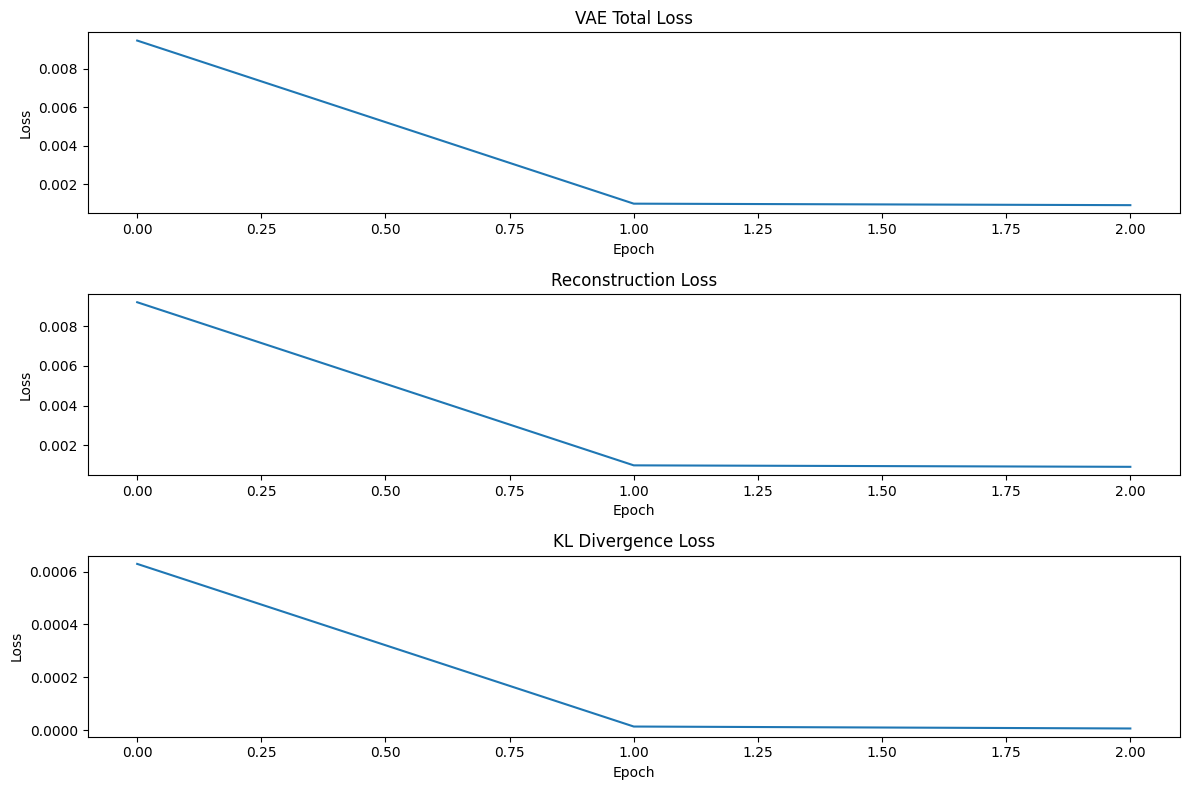

In [19]:
# Define VAE hyperparameters
latent_dim = 128           # Dimensionality of the latent space
num_epochs = 5          # Number of training epochs
learning_rate = 1e-4      # Learning rate (reduced for stability)

# Initialize VAE
print("Initializing VAE...")
vae = VAE(image_size=32, image_channels=1, latent_dim=latent_dim)

# Verify model initialization
if check_model_init(vae):
    print("Model initialization verified: No NaN values in parameters")
else:
    print("ERROR: Model has NaN values in parameters. Fix initialization.")

# Train VAE (uncomment to run training)
print("Training VAE...")
trained_vae = train_vae(
    vae=vae,
    dataloader=train_loader,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    device=device,
    checkpoint_dir=output_dir
)

## 7. Load Trained VAE and Visualize Reconstructions

After training, you can load the saved model and visualize reconstructions

Loading trained VAE from: vae_output/vae_final.pt
VAE loaded successfully!


Building image dataset: 100%|██████████| 5/5 [00:00<00:00,  9.12it/s]


Created dataset with 40000 images
Image tensor shape: torch.Size([40000, 1, 32, 32])
Image value range: [-0.824138, 0.921018]
Image mean: -0.000167, std: 0.030161


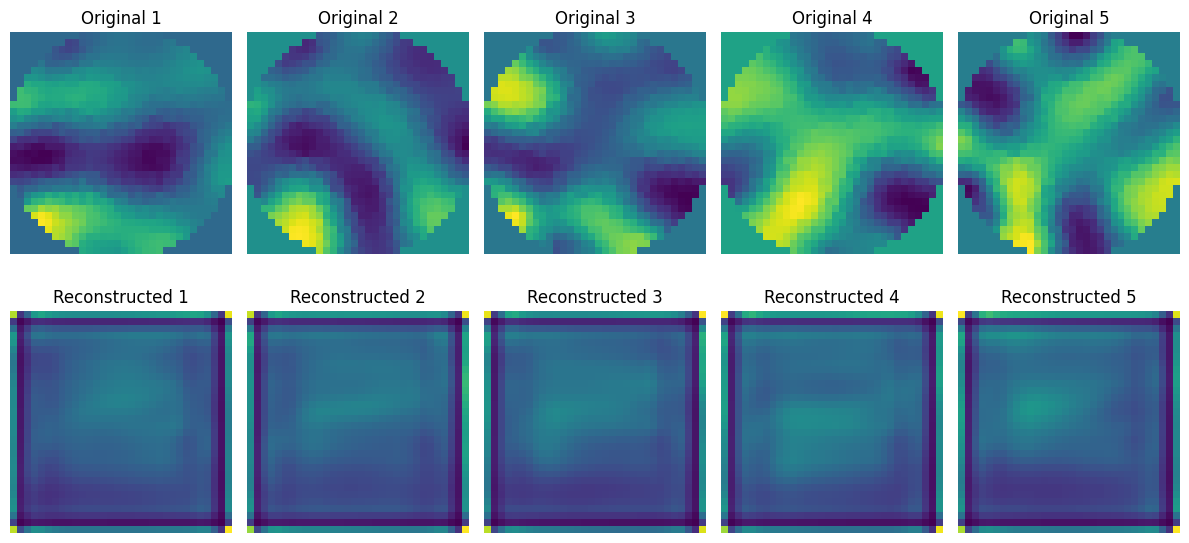

In [20]:
# Path to saved VAE model
vae_model_path = os.path.join(output_dir, 'vae_final.pt')

# Load trained VAE (uncomment after training is complete)
print(f"Loading trained VAE from: {vae_model_path}")
vae = VAE(image_size=32, image_channels=1, latent_dim=latent_dim)
vae.load_state_dict(torch.load(vae_model_path))
print("VAE loaded successfully!")

# Create a small image dataset for visualization
image_dataset = ImageDataset(test_loader)
viz_loader = DataLoader(image_dataset, batch_size=10, shuffle=True)

# Visualize reconstructions
visualize_reconstructions(vae, viz_loader, num_examples=5, device=device)

## 8. Explore the Latent Space

Visualize the latent space of the trained VAE

In [ ]:
def visualize_latent_space(vae, test_loader, device='cuda'):
    """Generate and visualize encodings in the latent space"""
    vae.eval()
    vae.to(device)
    
    # Create image dataset
    image_dataset = ImageDataset(test_loader)
    image_loader = DataLoader(image_dataset, batch_size=1000, shuffle=False)
    
    # Get a batch of images
    images = next(iter(image_loader))
    
    # Generate embeddings
    with torch.no_grad():
        images = images.to(device)
        mu, logvar = vae.encode(images)
        z = vae.reparameterize(mu, logvar)
    
    # Convert to CPU and numpy for plotting
    z = z.cpu().numpy()
    
    # Plot the first two dimensions of the latent space
    plt.figure(figsize=(10, 8))
    plt.scatter(z[:, 0], z[:, 1], alpha=0.5, s=5)
    plt.title('VAE Latent Space (First 2 Dimensions)')
    plt.xlabel('z[0]')
    plt.ylabel('z[1]')
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, 'latent_space_visualization.png'))
    plt.show()
    
    # Plot latent space distribution histograms
    plt.figure(figsize=(15, 5))
    
    # Plot histograms for the first 10 latent dimensions
    for i in range(min(10, z.shape[1])):
        plt.subplot(2, 5, i+1)
        plt.hist(z[:, i], bins=30, alpha=0.7)
        plt.title(f'z[{i}]')
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'latent_space_histograms.png'))
    plt.show()

# Visualize latent space (uncomment after training is complete)
visualize_latent_space(vae, test_loader, device=device)

NameError: name 'vae' is not defined

## 9. Generate Images from Latent Space

Explore the generative capabilities of the VAE by decoding points in the latent space

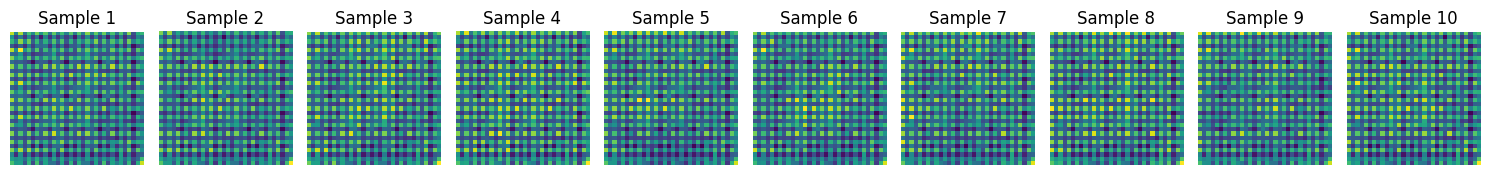

In [10]:
def generate_from_latent(vae, num_samples=10, latent_dim=64, device='cuda'):
    """Generate images by sampling from the latent space"""
    vae.eval()
    vae.to(device)
    
    # Sample random points from the latent space
    with torch.no_grad():
        # Sample from standard normal distribution
        z = torch.randn(num_samples, latent_dim).to(device)
        
        # Decode the latent vectors
        generated_images = vae.decode(z)
    
    # Convert to CPU and numpy for plotting
    generated_images = generated_images.cpu().numpy()
    
    # Plot generated images
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(generated_images[i].reshape(32, 32), cmap='viridis')
        plt.title(f"Sample {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'generated_samples.png'))
    plt.show()

# Generate images from latent space (uncomment after training is complete)
generate_from_latent(vae, num_samples=10, latent_dim=latent_dim, device=device)

## 10. Save VAE Encoder for Later Use in Joint Model

In [11]:
def extract_encoder(vae, output_path):
    """Extract and save only the encoder part of the VAE"""
    encoder_state = {
        'encoder': vae.encoder.state_dict(),
        'fc_mu': vae.fc_mu.state_dict(),
        'latent_dim': vae.fc_mu.out_features
    }
    
    torch.save(encoder_state, output_path)
    print(f"Encoder extracted and saved to: {output_path}")

# Extract and save encoder (uncomment after training is complete)
encoder_path = os.path.join(output_dir, 'vae_encoder.pt')
extract_encoder(vae, encoder_path)

Encoder extracted and saved to: vae_output/vae_encoder.pt
